In [1]:
import numpy as np
from tqdm import tqdm


class FrequencyAllocator:
    def __init__(self, qubit_min=4.0, qubit_max=6.0, num_qubits=2):
        self.qubit_min = qubit_min
        self.qubit_max = qubit_max
        self.num_qubits = num_qubits
        self.qubit_qubit_interactions = {}
        self.qubit_snail_interactions = {}
        self.bare_frequencies = [qubit_min, qubit_max]
        self.snail = None
        self.min_spacing = float("inf")
        self.avg_spacing = float("inf")
        self._update_interactions()

        while len(self.bare_frequencies) < self.num_qubits:
            self.add_qubit()
        self.add_snail()

    @property
    def all_interactions(self):
        return (
            list(self.qubit_qubit_interactions.keys())
            + list(self.qubit_snail_interactions.keys())
            + self.bare_frequencies
            + [self.snail]
        )

    def _update_interactions(self):
        # Reset and calculate qubit-qubit interactions.
        self.qubit_qubit_interactions = {}
        for i, freq1 in enumerate(self.bare_frequencies):
            for j, freq2 in enumerate(self.bare_frequencies[i + 1 :], start=i + 1):
                interaction_freqs = [freq1 + freq2, abs(freq1 - freq2)]
                for f in interaction_freqs:
                    if f not in self.qubit_qubit_interactions:
                        self.qubit_qubit_interactions[f] = []
                    self.qubit_qubit_interactions[f].append((i, j))

    def _add_snail_interactions(self):
        # Directly calculate and update interactions for the SNAIL with all qubits.
        if self.snail is not None:
            self.qubit_snail_interactions = {}
            for i, freq in enumerate(self.bare_frequencies):
                interaction_freqs = [freq + self.snail, abs(freq - self.snail)]
                for f in interaction_freqs:
                    if f not in self.qubit_snail_interactions:
                        self.qubit_snail_interactions[f] = []
                    self.qubit_snail_interactions[f].append((i, "S"))  # 'S' for SNAIL

    def _potential_interactions(self, new_freq):
        # Ensure SNAIL is added last as per requirements.
        assert self.snail is None, "SNAIL should be added last."
        # Calculate potential interactions for a new qubit frequency.
        return [new_freq + freq for freq in self.bare_frequencies] + [
            abs(new_freq - freq) for freq in self.bare_frequencies
        ]

    def _evaluate_new_frequency(self, new_freq, is_snail=False):
        potential_interactions = self._potential_interactions(new_freq)

        # Construct the list of all interactions, always including the new frequency and potential interactions.
        all_interactions = (
            self.bare_frequencies
            + [new_freq]  # Include the new frequency for consideration.
            + list(self.qubit_qubit_interactions.keys())
            + potential_interactions  # Include potential new interactions.
            + list(
                self.qubit_snail_interactions.keys()
            )  # SNAIL interactions are always considered.
        )

        # Check for duplicates to handle the case where the new frequency exactly matches an existing frequency.
        if len(all_interactions) != len(set(all_interactions)):
            return 0, 0  # Return the worst score for duplicates, as specified.

        # Sort all interactions to optimize nearest neighbor search.
        all_interactions_sorted = sorted(all_interactions)

        distances = []
        # Prepare the list of frequencies to evaluate based on whether we're adding a SNAIL or not.
        candidate_interactions = list(self.qubit_qubit_interactions.keys()) + (
            potential_interactions if not is_snail else []
        )

        for base_freq in candidate_interactions:
            # Find the position of base_freq in the sorted list to efficiently find its nearest neighbors.
            pos = all_interactions_sorted.index(base_freq)
            # Calculate distances to the nearest neighbors in the sorted list.
            if pos > 0:
                left_distance = abs(base_freq - all_interactions_sorted[pos - 1])
            else:
                left_distance = float("inf")

            if pos < len(all_interactions_sorted) - 1:
                right_distance = abs(base_freq - all_interactions_sorted[pos + 1])
            else:
                right_distance = float("inf")

            # The nearest neighbor distance is the minimum of the left and right distances.
            nearest_neighbor_distance = min(left_distance, right_distance)
            distances.append(nearest_neighbor_distance)

        # Calculate and return the minimum and average of the nearest neighbor distances.
        # if distances:
        return min(distances), sum(distances) / len(distances)

    def _find_optimal_frequency(self, is_snail=False):
        optimal_freq = None
        best_min_distance = -np.inf
        best_avg_distance = -np.inf
        for freq in np.linspace(self.qubit_min, self.qubit_max, 1800):
            min_distance, avg_distance = self._evaluate_new_frequency(
                freq, is_snail=is_snail
            )

            # Check if the new score is better based on min distance and then avg distance for tie-breaking.
            if min_distance > best_min_distance or (
                min_distance == best_min_distance and avg_distance > best_avg_distance
            ):
                best_min_distance = min_distance
                best_avg_distance = avg_distance
                optimal_freq = freq

        # Update class attributes with the current costs.
        self.min_spacing, self.avg_spacing = best_min_distance, best_avg_distance

        return optimal_freq

    def add_qubit(self):
        # Add a new qubit with an optimal frequency and update interactions accordingly.
        new_freq = self._find_optimal_frequency(is_snail=False)
        self.bare_frequencies.append(new_freq)
        self._update_interactions()

    def add_snail(self):
        # Ensure SNAIL tie-breaking logic is correctly handled.
        self.snail = self._find_optimal_frequency(is_snail=True)
        self._add_snail_interactions()

    def __str__(self):
        return f"Optimized Bare Frequencies: {self.bare_frequencies}\nOptimized SNAIL Frequency: {self.snail}\nMin Spacing: {self.min_spacing}\nAvg Spacing: {self.avg_spacing}"

    def _plot(self):
        # Plot the optimized frequencies and interactions.
        fig, ax = plt.subplots(figsize=(16, 2))
        height = self.qubit_max * 1.1
        ax.set_xlim(0, height)
        ax.get_yaxis().set_visible(False)
        plt.title("Parametric Drive Frequencies")

        # Plot the bare frequencies.
        for i, freq in enumerate(self.bare_frequencies):
            ax.axvline(freq, color="green", linestyle="-", linewidth=3)
            ax.text(freq, freq / height, f"Q{i}", rotation=90)

        # Plot the SNAIL frequency.
        ax.axvline(self.snail, color="red", linestyle="-", linewidth=2)
        ax.text(self.snail, self.snail / height, "S", rotation=90)

        # Plot the interaction frequencies.
        for freq, pair in self.qubit_qubit_interactions.items():
            if freq > self.qubit_max:
                continue

            ax.axvline(freq, color="blue", linestyle="-", linewidth=3, alpha=0.5)
            # annotate with pair
            ax.text(freq, freq / height, f"{pair}", rotation=90)

        for freq, pair in self.qubit_snail_interactions.items():
            if freq > self.qubit_max:
                continue
            ax.axvline(freq, color="purple", linestyle="-", linewidth=3, alpha=0.5)
            # annotate with pair
            ax.text(freq, freq / height, f"{pair}", rotation=90)

        # x-axis is Ghz
        plt.xlabel("GHz")

        plt.show()


# Example usage
allocator = FrequencyAllocator(num_qubits=3)  # Adjust the number of qubits as needed.
print(allocator)

Optimized Bare Frequencies: [4.0, 6.0, 4.665925514174542]
Optimized SNAIL Frequency: 5.667593107281823
Min Spacing: 0.33240689271817736
Avg Spacing: 0.4441356309060593


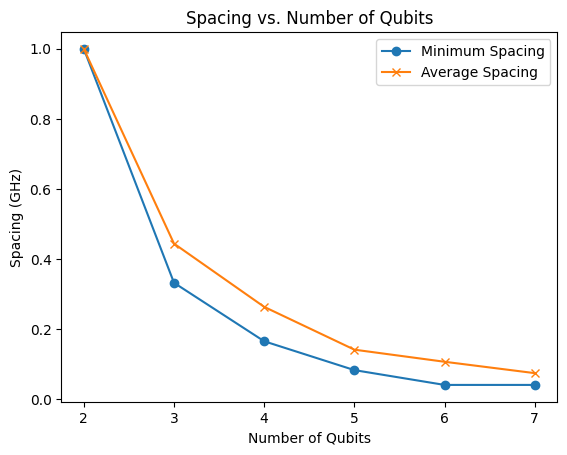

In [2]:
from matplotlib import pyplot as plt

# plot min_spacing and avg_spacing as a function of num_qubits
min_spacings = []
avg_spacings = []
num_qubits = list(range(2, 8))
for n in num_qubits:
    allocator = FrequencyAllocator(num_qubits=n)
    min_spacings.append(allocator.min_spacing)
    avg_spacings.append(allocator.avg_spacing)

fig, ax = plt.subplots()
ax.plot(num_qubits, min_spacings, label="Minimum Spacing", marker="o")
ax.plot(num_qubits, avg_spacings, label="Average Spacing", marker="x")
ax.set_xlabel("Number of Qubits")
ax.set_ylabel("Spacing (GHz)")
ax.set_title("Spacing vs. Number of Qubits")
ax.legend()
plt.show()

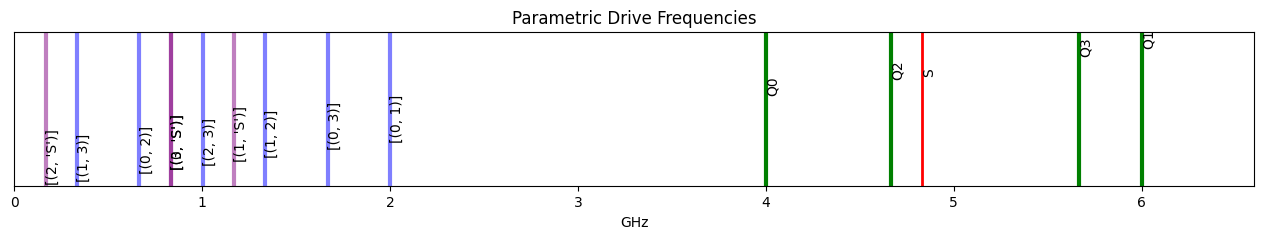

In [6]:
allocator = FrequencyAllocator(num_qubits=4)
allocator._plot()

In [6]:
allocator.bare_frequencies, allocator.snail

([4.0, 6.0, 4.665925514174542], 5.667593107281823)

In [6]:
wp = [w for w in allocator.qubit_qubit_interactions if w < 4]
wp = wp[0]
wp

2.0

In [37]:
exp_term = [w - wp for w in allocator.all_interactions]
# keep the 3 smallest absolute values
values = np.argsort(np.abs(exp_term))[:3]
# from these values, index back into the original list
values = [allocator.all_interactions[value] for value in values]

for value in values:
    if value in allocator.qubit_qubit_interactions:
        print(allocator.qubit_qubit_interactions[value])
        index = list(allocator.qubit_qubit_interactions.keys()).index(value)
        print(exp_term[index])
    elif value in allocator.qubit_snail_interactions:
        print(allocator.qubit_snail_interactions[value])
        index = list(allocator.qubit_snail_interactions.keys()).index(value)
        print(exp_term[index])
    else:  # must be a bare frequency
        print("?")
        index = allocator.all_interactions.index(value)
        print(exp_term[index])

[(0, 1)]
0.0
[(0, 3)]
-0.33240689271817736
[(1, 2)]
-0.6659255141745417


In [51]:
# from quantum_logical.pulsesim import QuantumSystem, Pulse
# from quantum_logical.pulsesim.mode import QubitMode, SNAILMode

# qubits = []
# for qubit in allocator.bare_frequencies:
#     qubit = QubitMode(name=f"q{qubit}", freq=qubit, dim=2, alpha=0)
#     qubits.append(qubit)

# snail = SNAILMode(name="s", freq=allocator.snail, g3=0.3, dim=10)

# # couplings
# # _couplings = {
# #     frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
# #     frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
# #     frozenset([qubit3, snail]): 2 * np.pi * 0.04875,
# # }
# _couplings = {frozenset([q, snail]): 2 * np.pi * 0.05 for q in qubits}

# qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [54]:
# qs._lambda(qubits[0], qubits[1])

-0.0

In [55]:
# # we are going to assume no time-dependence
# epsilon = 0.1  # ampltiude (?)
# eta = 2 * wp * epsilon / (wp**2 - allocator.snail**2)

# H_eff = 0

# for i, qubit1 in enumerate(qubits):
#     for j, qubit2 in enumerate(qubits[i + 1 :], start=i + 1):
#         wi = qs.dressed_freqs[qubit1]
#         wj = qs.dressed_freqs[qubit2]
#         temp = (
#             6
#             * qs._lambda(snail, qubit1)
#             * qs._lambda(snail, qubit2)
#             * eta
#             * qs.modes_a[qubit1]
#             * qs.modes_a_dag[qubit2]
#             * (np.exp(-1j * wi -wj + wp)
#         )

(QubitMode(name=q4.0, freq=4.0 GHz, dim=2),
 QubitMode(name=q6.0, freq=6.0 GHz, dim=2))

In [ ]:
# import matplotlib.pyplot as plt
# from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Layout
# import numpy as np

# %matplotlib widget

# # Create a figure and axes for plotting
# fig, ax = plt.subplots(figsize=(10, 2))

# # Number of qubits can be adjusted here
# num_qubits = 5

# # Create sliders for qubits and SNAIL
# sliders = {
#     f"qubit_{i}": FloatSlider(
#         value=np.random.uniform(3, 6),
#         min=0,
#         max=6,
#         description=f"Qubit {i}",
#         # orientation="vertical",
#         continuous_update=False,
#         step=0.01,
#     )
#     for i in range(num_qubits)
# }
# sliders["snail"] = FloatSlider(
#     value=4.5,
#     min=3,
#     max=7,
#     description="SNAIL",
#     # orientation="vertical",
#     continuous_update=False,
#     step=0.01,
# )


# # initialize the dictionary
# initial_frequencies = np.linspace(3, 7, num_qubits + 1)  # +1 for SNAIL
# frequency_dict = {}
# for qubit in range(num_qubits):
#     frequency_dict[f"qubit_{qubit}"] = ax.axvline(
#         initial_frequencies[qubit], color="green", linestyle="-", linewidth=3
#     )
# frequency_dict["snail"] = ax.axvline(
#     initial_frequencies[-1], color="red", linestyle="-", linewidth=2
# )

# # add frequency pairs to the dictionary (sum and difference)
# # use frozenset() to ensure that the order of the keys doesn't matter
# for i, mode1 in enumerate(initial_frequencies):
#     for j, mode2 in enumerate(initial_frequencies):
#         if i == j:
#             continue
#         key1 = f"qubit_{i}"
#         key2 = f"qubit_{j}"
#         if i == len(initial_frequencies) - 1:
#             key1 = "snail"
#         if j == len(initial_frequencies) - 1:
#             key2 = "snail"

#         freq1 = initial_frequencies[i]
#         freq2 = initial_frequencies[j]

#         sum_freq = freq1 + freq2
#         diff_freq = abs(freq1 - freq2)
#         sum_key = f"sum_{key1}_{key2}"
#         diff_key = f"diff_{key1}_{key2}"
#         # frequency_dict[sum_key] = sum_freq
#         # frequency_dict[diff_key] = diff_freq

#         alpha = 1
#         if "snail" in sum_key:
#             color = "red"
#             # transparenet
#             # alpha = 0
#         else:
#             color = "blue"

#         frequency_dict[sum_key] = ax.axvline(
#             sum_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
#         )
#         frequency_dict[diff_key] = ax.axvline(
#             diff_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
#         )

# # Initialize plot properties
# ax.set_xlim(0, 14)
# ax.get_yaxis().set_visible(False)
# plt.title("Qubit and SNAIL Frequencies")


# # Function to update the plot
# def update_plot(**mode_frequencies):
#     # Update the frequency lines
#     for mode, freq in mode_frequencies.items():
#         frequency_dict[mode].set_xdata([freq, freq])

#     # update the pairs
#     for key1, freq1 in mode_frequencies.items():
#         for key2, freq2 in mode_frequencies.items():
#             if key1 == key2:
#                 continue
#             sum_freq = freq1 + freq2
#             diff_freq = abs(freq1 - freq2)
#             sum_key = f"sum_{key1}_{key2}"
#             diff_key = f"diff_{key1}_{key2}"
#             frequency_dict[sum_key].set_xdata([sum_freq, sum_freq])
#             frequency_dict[diff_key].set_xdata([diff_freq, diff_freq])

#     # Redraw the figure to update the lines
#     fig.canvas.draw_idle()


# # Layout adjustments for better UI
# slider_layout = VBox(list(sliders.keys()), layout=Layout(width="400"))
# plot_layout = interactive_output(update_plot, sliders)

# # Display the interactive widgets alongside the plot
# display(HBox([slider_layout, plot_layout]))